# Workflow
In this tutorial we present the main functionalities of our python package. The data set we will use is derived from REDIportal (http://srv00.recas.ba.infn.it/atlas/), a collection of primarily human RNA A-to-I editing locations and we are going to classify whether an editing location is located in an ALU repeat region, in another repetitive region (non-alu) or in a non-repetitive region. Thus, this is a 3-class single-label classification task. This data set is easy to classify, because repetitve regions tend to have strong sequence-structure motifs and the purpose of this tutorial is not a particular biological interpretation, but to showcase the main output and interpretation of the neural network.

## Input Data

Let's start by doing some imports and by setting up an output folder that will contain all output files in the end (you can find the output folder in the github repo, the prepaired input data can be found there as well: https://github.com/budach/pysster/tree/master/tutorials).

In [1]:
import os
#import import_ipynb
from time import time
from IPython.display import Image
from pysster.Data import Data
from pysster.Grid_Search import Grid_Search
from pysster import utils

output_folder = "example_editing/"
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

Using TensorFlow backend.


In [2]:
# A quick tensorflow test to make sure it's accessible from Jupyter

import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)
# Checkk to see if the Jupyter note book can 'see' your GPU, if not it will return an empty string: ''
tf.test.gpu_device_name()

TensorFlow version: 1.12.0


'/device:GPU:0'

The data set consists of sequences of length 301 centered at an editing site, that is, all sequences in all classes have an A at position 151. For every class we randomly sampled 50000 editing sites from REDIportal. We also predicted the secondary structures for all sequences using RNAfold and annotated the structures using a pysster utils function. The input for the network are fasta files containing the RNA sequences and corresponding secondary structures. A single entry looks like this:
```
> header
CCCCAUAGGGG
SSSSHHHSSSS
```
The third line shows the secondary structure as an annotated structure string and is based on a 4-letter alphabet: "H" means hairpin, "I" internal loop (or buldge), "M" multi loop and "S" means stem. Our package provides functions to predict basic RNA secondary structures and to annotate existing dot-bracket strings, have a look at the utils API documentation. We have already prepared three fasta files, one per class, and can now directly load these into a Data object.

We also have to provide the alphabets of our strings, "ACGU" and "HIMS" in this case, to construct a Data object. Pysster can handle arbitrary alphabets, that means, it is possible to use and combine (in the sequence-structure case) arbitrarily defined alphabets as long as the data is provided in the described fasta format. In particular, this means the usage of the package is not restricted to RNA secondary structure (this is only an example). If you have structure information for DNA or protein data that can be encoded by some alphabet, similar to RNA structure information, you can apply the package to this kind of data as well. Also, usage of structure information is optional. Have a look at the Data object API documentation for details.

In [1]:
data = Data(["data/alu.fa.gz",
             "data/rep.fa.gz",
             "data/nonrep.fa.gz"], ("ACGU", "HIMS"))
data.get_summary()

NameError: name 'Data' is not defined

Loading the data will also automatically compute a random 70%/15%/15% training/validation/test split. If you want to change these ratios or if you want to provide a seed for the random number generator to get reproducible splits you can do so:

In [5]:
data.train_val_test_split(portion_train=0.7, portion_val=0.15, seed=1775)
print(data.get_summary())

              class_0    class_1    class_2
all data:       50000      50000      50000
training:       34954      35030      35016
validation:      7533       7479       7488
test:            7513       7491       7496


## Model Training

We are now ready to train a model using the data. The basic architecture of the network consists of a variable number of convolutional and max-pooling layers followed by a variable number of dense layers. These layers are interspersed by dropout layers after the input layer and after every max-pooling and dense layer. The number of convolutional layers, the number of kernels, the length of kernels, dropout rates, etc. are all parameters that can be provided by the user

We will run a small hyperparameter grid search training 4 different models for the sake of the tutorial. We define lists of potential parameter values and the Grid_Search object will train all models on the training data and return the single model with the highest ROC-AUC on the validation data. In this case we will try models with either 1 or 2 convolutional layers and input dropout rates of 0.1 or 0.4. All convolutional layers will have 20 kernels, each of length 20. Parameters that are not defined in the "params" variable will have default values (see Model API doc).

If you don't want to do a grid search you can also directly train a single model:
```
params = {"conv_num": 2, "kernel_num": 20}
model = Model(params, data)
model.train(data)
```

However, for the tutorial we will run the grid search and we will also measure the runtime:

In [22]:
params = {"conv_num": [2, 3], "kernel_num": [25], "kernel_len": [20], "dropout_input": [0.1, 0.4]}
searcher = Grid_Search(params)
start = time()
model, summary = searcher.train(data, verbose=False)
stop = time()
print("time in minutes: {}".format((stop-start)/60))

time in minutes: 39.810096371173856


The grid search training also returns a summary string with the ROC-AUC of all models:

In [23]:
print(summary)

# conv_num: [2, 3]
# kernel_num: [25]
# kernel_len: [20]
# dropout_input: [0.1, 0.4]
conv_num kernel_num kernel_len dropout_input roc-auc
       3         25         20           0.1 0.96717
       2         25         20           0.1 0.96501
       3         25         20           0.4 0.95237
       2         25         20           0.4 0.95109



## Performance Evaluation

We can now perform the final evaluation of our model on the test data. Calling the predict function returns an array of shape (number of sequences, number of classes) holding predicted probabilities. Instead of passing "test" to the function you can also pass "train", "val" or "all". If you want to do predictions on a completely different Data object, make sure that the sequences in this Data object have the same length as the sequences you used for model training. Pass "all" to the predict function to get predictions for all sequences in a non-random order (that is, the order in which sequences where loaded from the fasta file).

In [24]:
predictions = model.predict(data, "test")
predictions

array([[1.0000000e+00, 2.5090554e-08, 3.5216107e-08],
       [1.0000000e+00, 4.3842537e-08, 2.7305744e-09],
       [4.0355317e-08, 7.3743576e-01, 2.6256430e-01],
       ...,
       [6.5173272e-10, 9.1536850e-02, 9.0846318e-01],
       [3.7602412e-08, 1.5914372e-01, 8.4085625e-01],
       [1.4278905e-07, 3.8668376e-01, 6.1331612e-01]], dtype=float32)

We also need the true labels and we can get them from the data object. The result is again an array of shape (number of sequences, number of classes).

In [25]:
labels = data.get_labels("test")
labels

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint32)

Given predictions and labels we can now create ROC and precision-recall curve plots and get an overview of a number of performance metrics. In a multi-class setting metrics are computed in 1 vs. all approach, as they are only really defined for binary classifications. Average values are weighted by the number of sequences 'n' in each class. You can get higher-quality output images by saving as pdf instead of png.

In [26]:
utils.plot_roc(labels, predictions, output_folder+"roc.png")
utils.plot_prec_recall(labels, predictions, output_folder+"prec.png")
print(utils.get_performance_report(labels, predictions))

             precision    recall  f1-score   roc-auc    pr-auc          n
     class_0     0.980     0.973     0.976     0.999     0.997  |    7513
     class_1     0.924     0.707     0.801     0.945     0.916  |    7491
     class_2     0.772     0.960     0.856     0.953     0.877  |    7496


weighted avg     0.892     0.880     0.878     0.966     0.930  |        




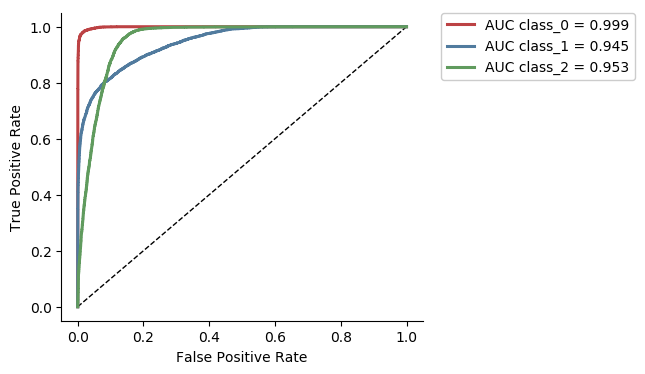

In [27]:
Image(output_folder+"roc.png")

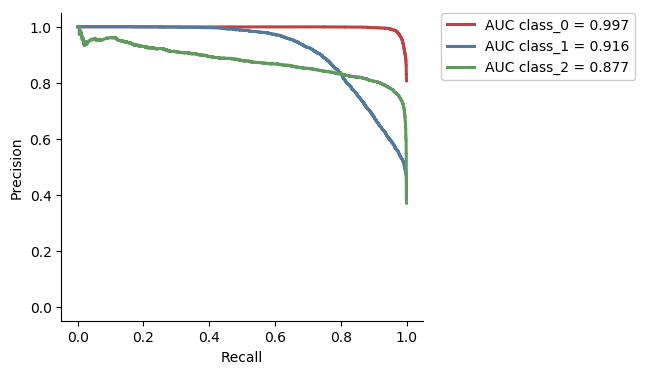

In [28]:
Image(output_folder+"prec.png")

## Motif Visualization And Interpretation

We will now visualize what motifs the kernels of the first convolutional layer have learned and where these motifs are located in our sequences.

The visualizations are based on our held-out test data. First, we need the output of the first convolutional layer given the test sequences. This output is called 'activations'. You can think of a kernel as a position-weight matrix (PWM) and activations are the result of sliding with the kernel over an input sequence, one position at a time. The result is a vector of numbers and the position of the maximum activation shows to which subsequence the kernel is most similar. If the maximum activation is above a certain threshold we can extract the corresponding subsequence of the length of the kernel from the input starting at that position. If we do this for all input sequences we get a number of subsequences, all of the same length, and we can compute a PWM. In addition, plotting the position of the maximum activation (e.g. as a histogram) shows exactly where our motifs are located. Doing all of this separately for every class also gives a class enrichment for our motifs.

To be able to handle RNA sequence/secondary structure input while maintaining the mentioned visualization options, we encode the sequence string and the corresponding secondary structure  string into a single new string using an extended alphabet. This already happens while loading the data and before training the model. More precisely, all possible combinations of characters from the RNA alphabet of length 4 ("ACGU") and the annotated secondary structure alphabet of length 4 ("HIMS") can be uniquely represented by an alphabet of length 16 comprised of arbitrary characters. The network is trained on the new strings and after the subsequences for the motif visualizations have been extracted, as described above, the subsequences are decoded into the two original strings. This makes it possible to compute and visualize two PWMs, one for the RNA alphabet and one for the annotated secondary structure alphabet.

Let's visualize all of our 20 kernels by calling the visualize_all_kernels() method. This function creates 3 output images for each kernel and it also returns a list of Motif objects holding the PWMs. It also outputs a "summary.html" file which shows all 3 output images for each kernel side-by-side to get an easy overview. Kernels are sorted by an importance score.

There is no consensus on how to compute feature importance for neural networks. In our case we compute the average maximum activation for every class and define the importance score as the difference between the maximum and the minimum of these values (this can be seen in the violin plots below). The idea is that kernels that show big activation differences across classes (i.e. kernels that are strongly enriched in one class and little to none in other classes) are more important for the network to deliver correct predictions. The importance score shows a global enrichment over all sequence positions and a low score does not mean that the motif is not biologically meaningful. Sometimes motifs might show a similar global enrichment in multiple classes, but at the same time they might also show very different positional enrichments in these classes (as indicated by the histograms, example below). You should always consider the positional enrichment plots and your domain knowledge of the data at hand when interpreting the results. The global importance score only gives a rough guide on where to start.

In [29]:
activations = model.get_max_activations(data, "test")
logos = model.visualize_all_kernels(activations, data, output_folder)

The summary.html output and all individual output images can be found in output_folder. For my run, the summary report looks like this: https://htmlpreview.github.io/?https://github.com/budach/pysster/blob/master/tutorials/example_editing/summary.html.

As said, the function creates three plots for every kernel and we will now have a closer look at kernel 13. Here is the sequence-structure motif:

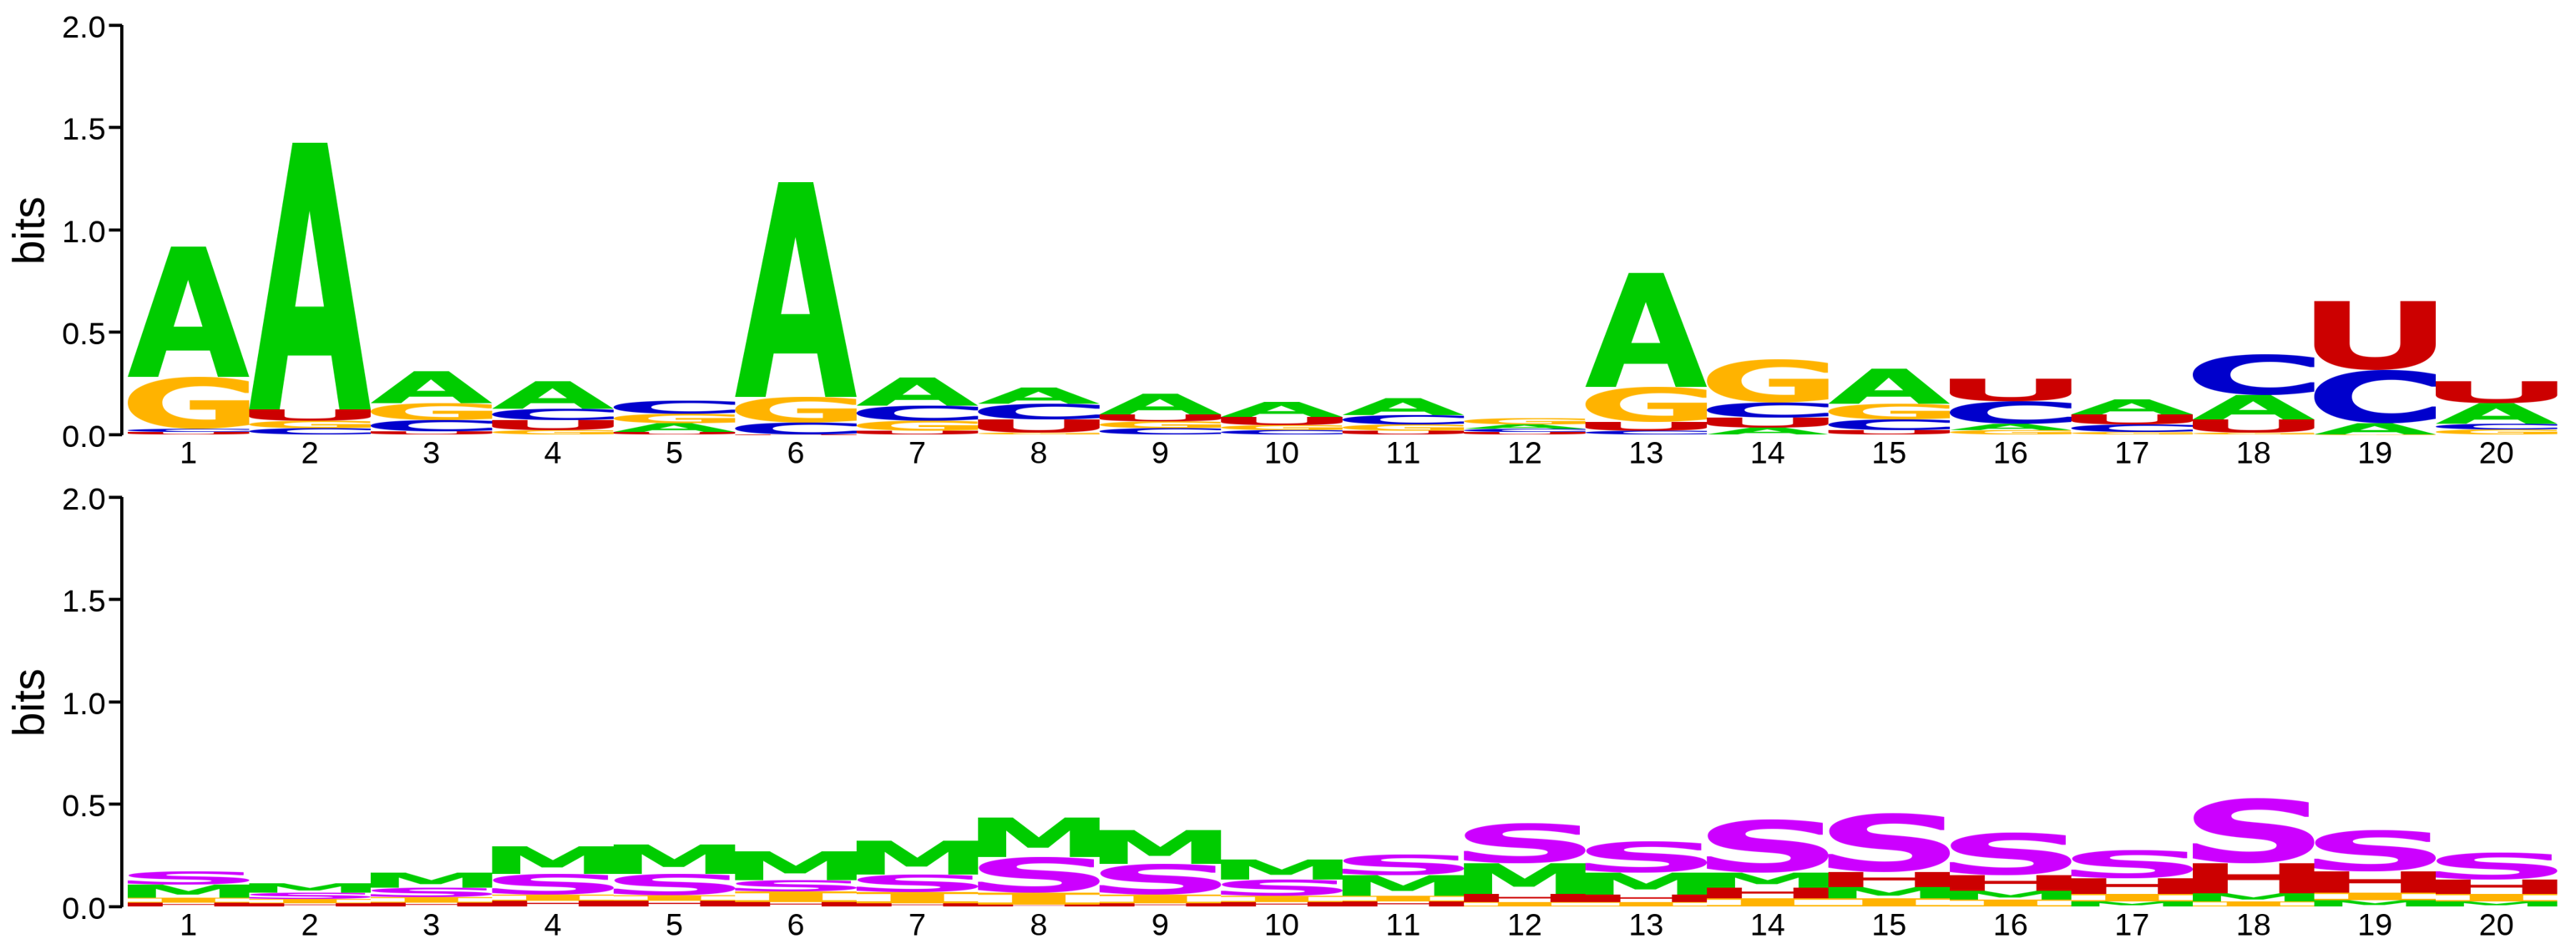

In [30]:
Image(output_folder+"motif_kernel_13.png")

The next plot shows the distribution of the maximum activations for every class. The importance score mentioned earlier can be seen here, it is the average max activation of class_0 minus the average max activation of class_2 (=0.170). Looking at the plot shows that this kernel is enriched in class_0, the ALU repeat class:

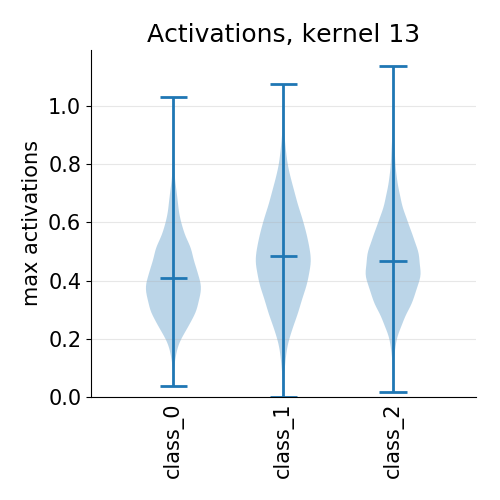

In [31]:
Image(output_folder+"activations_kernel_13.png")

The next image shows the positional enrichment of the kernel, that is, the position of the maximum activations as talked about earlier (the histograms). The plots below the histograms show the mean activations for all sequence positions (+/- standard deviation as a light band). Both plots are only based on sequences that led to a maximum activation higher than a certain threshold (the maximum average max activation, see class_0 in the plot above). Histogram and mean activation plot are usually identical, but in case the histogram is very sparse or classes are imbalanced the mean activation plot might be easier to look at.

In this case, we only have a strong signal for the ALU class and if we have a closer look we can see that the motif has its strongest enrichment at position 150 and 151. As mentioned at the very beginning the editing position is always at position 151, indicating that the two A's at the beginning of our motif might be often edited (if you read this on github and the image is too small right-click it and click View/Open image in new tab):

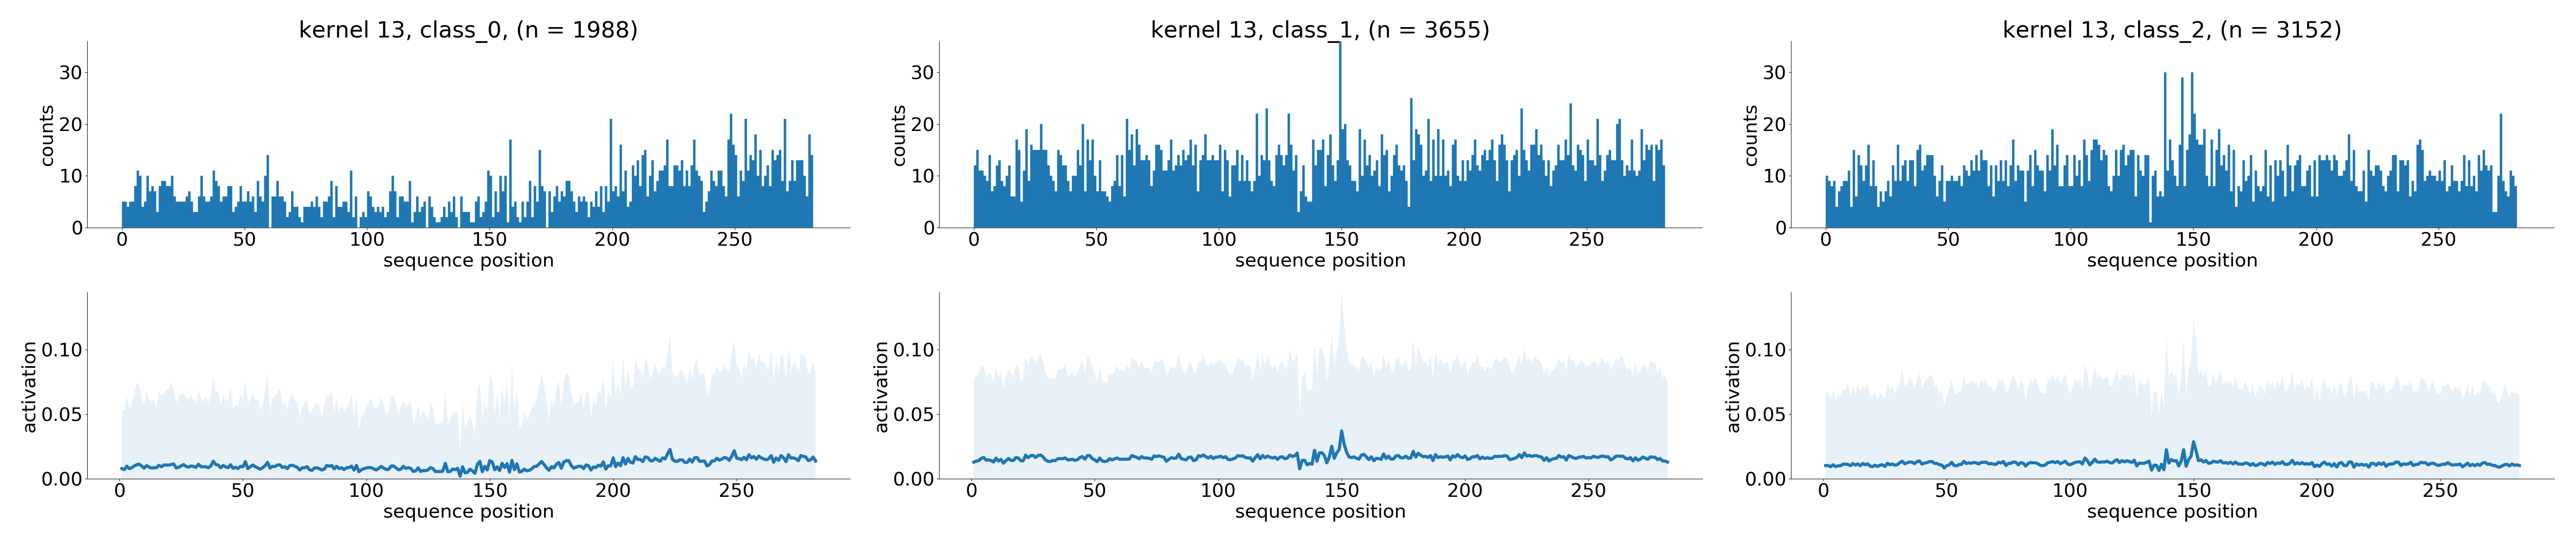

In [32]:
Image(output_folder+"position_kernel_13.png")

ALU repeats tend to form a specific secondary structure (shown below), and in fact, comparing our motif with the ALU structure shows a perfect match for both sequence and structure motif starting at position 27 (the image is adapted from http://www.mdpi.com/1422-0067/14/7/13307/htm):

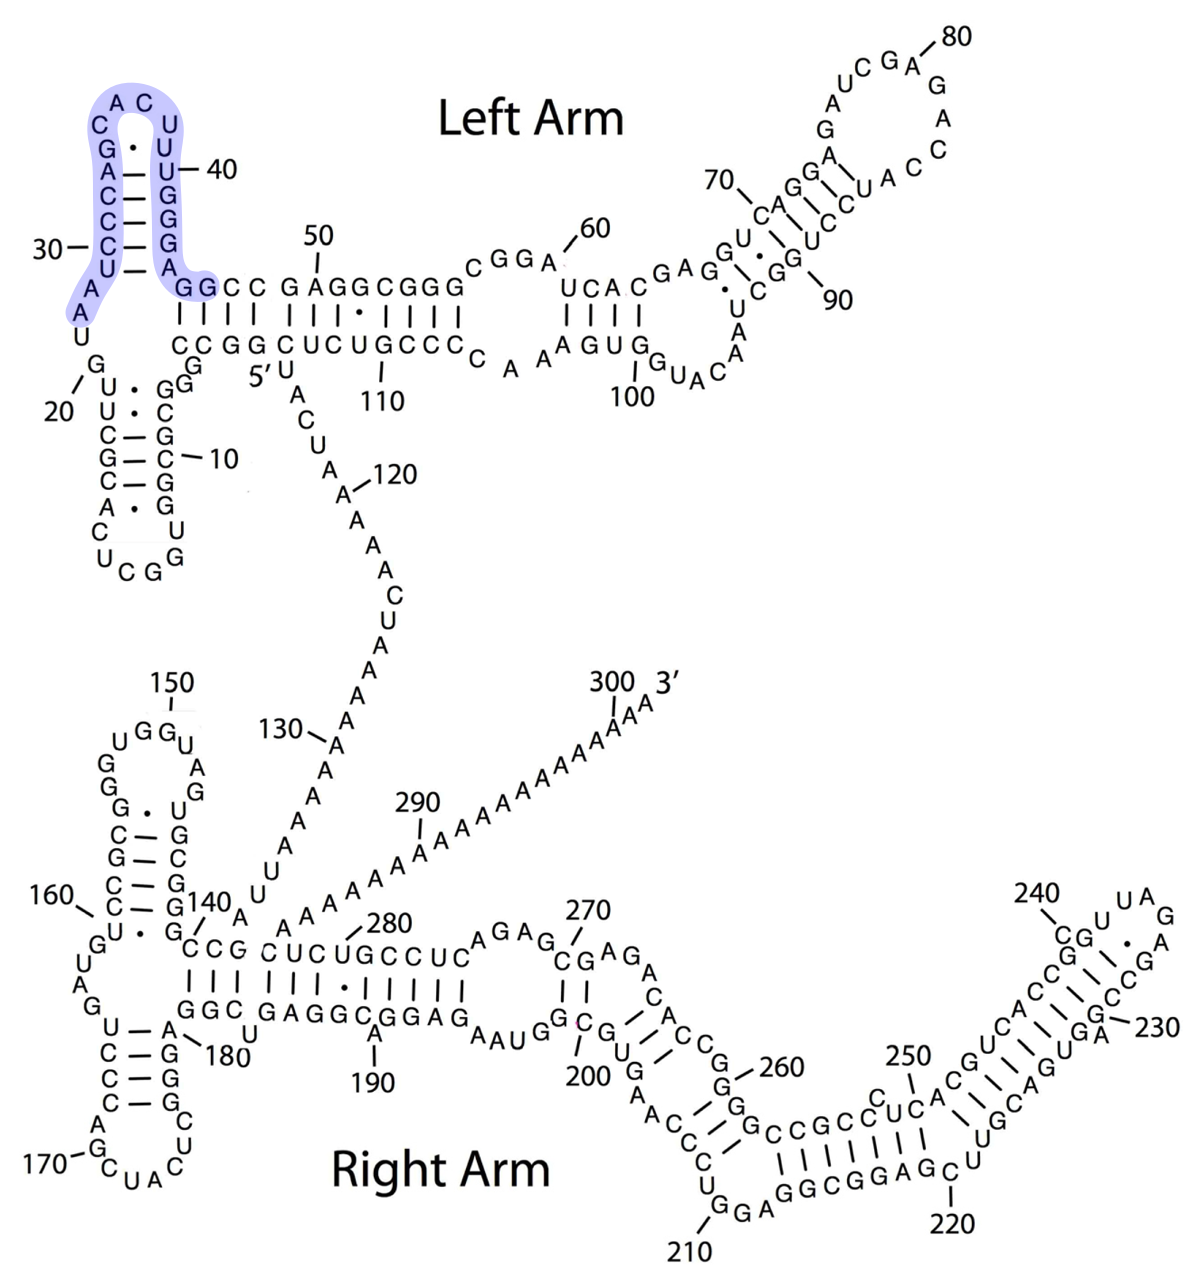

In [33]:
Image("data/alu.png")

We are almost done. To save the motifs for further processing we can save them in MEME format. For a sequence-structure data set the logo variable holds a tuple of Motif objects, the first tuple entry is the sequence motif and the second the structure motif.

In [34]:
utils.save_as_meme([logo[0] for logo in logos], output_folder+"motifs_seq.meme")
utils.save_as_meme([logo[1] for logo in logos], output_folder+"motifs_struct.meme")

We can do one more thing with our maximum activations from earlier and that is computing a hierarchical clustering of both sequences and kernels based on the maximum activations matrix. In an ideal world the clustering will show you co-occurring motifs. In practice, you will often see that the network learns strong motifs multiple times and these will of course be close to each other in the cluster matrix. Neural networks are notoriously hard to interpret and require detours to get information. Nevertheless, the clustering gives a rough guide on where to start looking (columns are sequences, rows are kernels):

C:\Users\Admin\Anaconda3\envs\tf-gpu\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\Admin\Anaconda3\envs\tf-gpu\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


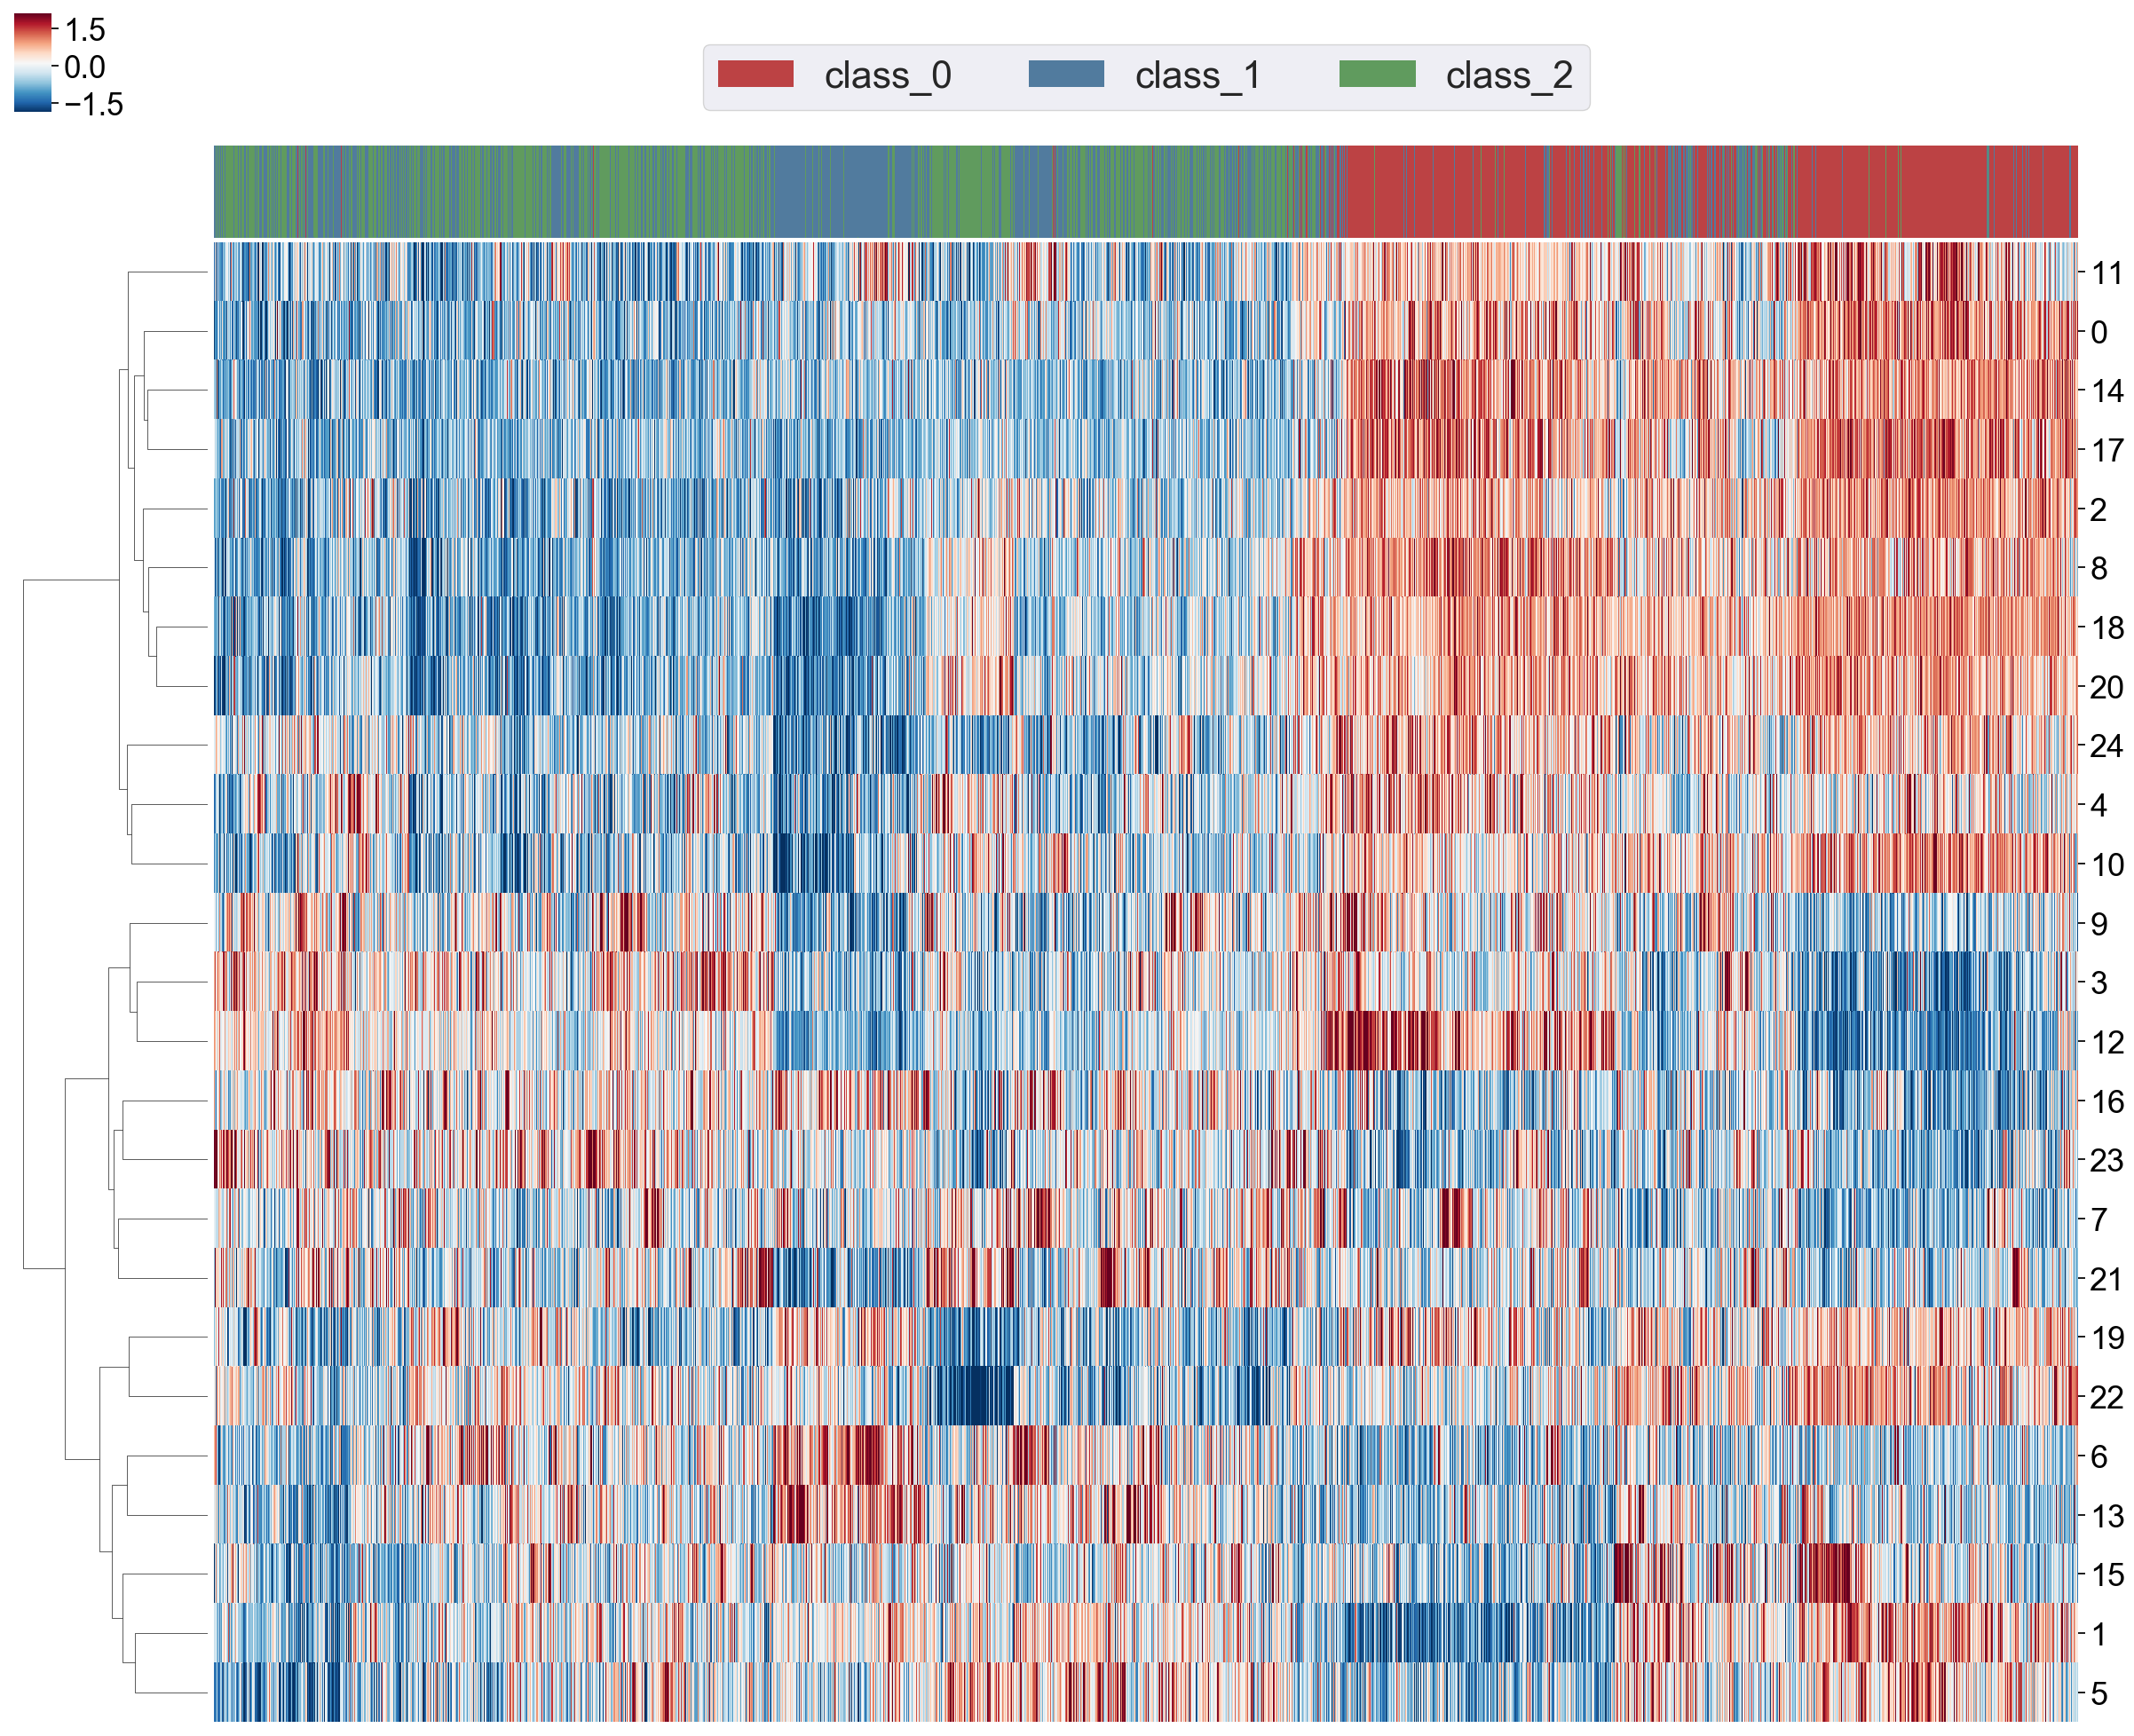

In [35]:
model.plot_clustering(activations, output_folder+"clustering.png")
Image(output_folder+"clustering.png")

## Further Reading & Features

And that is all about the main functionality of the network. Have a look at the API documentation to learn more about unmentioned parameters of some functions (e.g. you can also insert recurrent LSTM or GRU layers into the network (Model API docu), you can add additional handcrafted input features (Data API docu) and you can input a PWM into the model instead of a single secondary structure string (Data API docu)). Also have a look at the second tutorial if you want to learn more about visualizations beyond the first network layer.

In [36]:
utils.save_data(data, output_folder+"data.pkl")
utils.save_model(model, output_folder+"model.pkl")